## Imports: libraries and dataset

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import itertools
from statsmodels.tsa.stattools import adfuller

import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR

from sklearn.preprocessing import StandardScaler

In [14]:
# Load the dataset
df = pd.read_csv('../../dataset/KAG_energydata_complete.csv')

# Convert the 'date' column to datetime format and set it as the index
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

Standardize the dataset

In [15]:
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), index=df.index, columns=df.columns)

## Arima model

In [16]:
# Focusing on the 'Appliances' energy consumption
series = df_scaled['Appliances']

In [17]:
# Perform ADF test to check for stationarity
result = adfuller(series)
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -21.61637819803618
p-value: 0.0


In [18]:
# If the p-value is greater than 0.05, difference the series
if result[1] > 0.05:
    series = series.diff().dropna()

In [19]:
# Parameter tuning for ARIMA using a smaller range for efficiency
p = d = q = range(0, 3)
best_aic = float("inf")
best_params = None
num_combinations = len(list(itertools.product(p, d, q)))

print(f"Total combinations to evaluate: {num_combinations}")

Total combinations to evaluate: 27


In [ ]:
count = 0

for param in itertools.product(p, d, q):
    count += 1
    print(f"Evaluating combination {count}/{num_combinations}: ARIMA{param}")
    try:
        model = ARIMA(series, order=param)
        results = model.fit()
        if results.aic < best_aic:
            best_aic = results.aic
            best_params = param
    except Exception as e:
        print(f"Combination {param} failed with error: {e}")
        continue

print('Best ARIMA parameters:', best_params)
print('Best AIC:', best_aic)


In [21]:
# Fit the ARIMA model with the best parameters
model = ARIMA(series, order=best_params)
model_fit = model.fit()

/home/stas/.local/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 10min will be used.
  self._init_dates(dates, freq)
/home/stas/.local/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 10min will be used.
  self._init_dates(dates, freq)
/home/stas/.local/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 10min will be used.
  self._init_dates(dates, freq)


In [22]:
# Forecast
forecast_steps = 30  # Forecast for 30 time steps ahead
forecast = model_fit.forecast(steps=forecast_steps)

In [38]:
# Evaluate the model
y_train = series[:-forecast_steps]
y_test = series[-forecast_steps:]
y_pred = model_fit.predict(start=len(series) - forecast_steps, end=len(series) - 1)

arima_mae = mean_absolute_error(y_test, y_pred)
arima_mse = mean_squared_error(y_test, y_pred)
arima_rmse = np.sqrt(arima_mse)
arima_r2 = r2_score(y_test, y_pred)

print('Mean Absolute Error (MAE):', arima_mae)
print('Mean Squared Error (MSE):', arima_mse)
print('Root Mean Squared Error (RMSE):', arima_rmse)
print('R-squared:', arima_r2)

Mean Absolute Error (MAE): 0.3880643357459601
Mean Squared Error (MSE): 0.35395256113106405
Root Mean Squared Error (RMSE): 0.5949391238866915
R-squared: 0.6307932969319153


## Sarima model

In [24]:
# Focusing on the 'Appliances' energy consumption and selecting exogenous variables
series = df_scaled['Appliances']
# exog = df[['T1', 'RH_1', 'T2', 'RH_2', 'T_out', 'RH_out']]

In [25]:
# Fit the SARIMAX model with the selected parameters and exogenous variables
model = SARIMAX(series,
                order=(2, 0, 2),
                seasonal_order=(1, 0, 1, 24),
                #exog=exog,
                enforce_stationarity=False,
                enforce_invertibility=False)
model_fit = model.fit(disp=False)

# Print summary of the model
print(model_fit.summary())

/home/stas/.local/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 10min will be used.
  self._init_dates(dates, freq)
/home/stas/.local/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 10min will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                           Appliances   No. Observations:                19735
Model:             SARIMAX(2, 0, 2)x(1, 0, [1], 24)   Log Likelihood              -19252.130
Date:                              Wed, 10 Jul 2024   AIC                          38518.260
Time:                                      19:29:58   BIC                          38573.481
Sample:                                  01-11-2016   HQIC                         38536.339
                                       - 05-27-2016                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3395      0.013    104.446      0.000       1.314       1.365
ar.L2         -0.36

In [26]:
# Forecast
forecast_steps = 30  # Forecast for 30 time steps ahead
# exog_forecast = exog.iloc[-forecast_steps:].reset_index(drop=True)
# forecast = model_fit.forecast(steps=forecast_steps, exog=exog_forecast)
forecast = model_fit.forecast(steps=forecast_steps)

In [37]:
# Evaluate the model
y_train = series[:-forecast_steps]
y_test = series[-forecast_steps:]
y_pred = model_fit.predict(start=len(series) - forecast_steps, end=len(series) - 1)

sarima_mae = mean_absolute_error(y_test, y_pred)
sarima_mse = mean_squared_error(y_test, y_pred)
sarima_rmse = np.sqrt(sarima_mse)
sarima_r2 = r2_score(y_test, y_pred)

print('Mean Absolute Error (MAE):', sarima_mae)
print('Mean Squared Error (MSE):', sarima_mse)
print('Root Mean Squared Error (RMSE):', sarima_rmse)
print('R-squared:', sarima_r2)

Mean Absolute Error (MAE): 0.3880643357459601
Mean Squared Error (MSE): 0.35395256113106405
Root Mean Squared Error (RMSE): 0.5949391238866915
R-squared: 0.6307932969319153


By removing the other independent variables, the sarima model improved marginally

## ETS model

In [29]:
# Resample the data to daily frequency and take the mean
daily_data = df_scaled['Appliances'].resample('D').mean()

In [30]:
# Fit an ETS model
ets_model = sm.tsa.ExponentialSmoothing(daily_data, trend='add', seasonal='add', seasonal_periods=7).fit()

In [31]:
# Summary of the ETS model
ets_summary = ets_model.summary()
print(ets_summary)

                       ExponentialSmoothing Model Results                       
Dep. Variable:               Appliances   No. Observations:                  138
Model:             ExponentialSmoothing   SSE                             10.997
Optimized:                         True   AIC                           -327.092
Trend:                         Additive   BIC                           -294.893
Seasonal:                      Additive   AICC                          -324.157
Seasonal Periods:                     7   Date:                 Wed, 10 Jul 2024
Box-Cox:                          False   Time:                         19:30:43
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level              1.4901e-08                alpha                 True
smoothing_trend          

In [32]:
# Forecasting
forecast_steps = 30  # Forecast for the next 30 days
ets_forecast = ets_model.forecast(steps=forecast_steps)

actual_values = daily_data[-forecast_steps:]  # Actual values for the forecast period

In [36]:
# Calculate error metrics
ets_mae = mean_absolute_error(actual_values, ets_forecast)
ets_mse = mean_squared_error(actual_values, ets_forecast)
ets_rmse = np.sqrt(ets_mse)
ets_r2 = r2_score(actual_values, ets_forecast)

print('Mean Absolute Error (MAE):', ets_mae)
print('Mean Squared Error (MSE):', ets_mse)
print('Root Mean Squared Error (RMSE):', ets_rmse)
print('R-squared:', ets_r2)

Mean Absolute Error (MAE): 0.2189629272424196
Mean Squared Error (MSE): 0.07145463075783827
Root Mean Squared Error (RMSE): 0.26730999000755334
R-squared: 0.038837338396857435


In [34]:
z_scores = (ets_forecast - actual_values.mean()) / actual_values.std()
print('Z-scores:', z_scores)

Z-scores: 2016-05-28    0.254474
2016-05-29   -0.143901
2016-05-30    0.465292
2016-05-31   -0.421815
2016-06-01   -0.323202
2016-06-02   -0.305488
2016-06-03    0.207060
2016-06-04    0.246422
2016-06-05   -0.151954
2016-06-06    0.457240
2016-06-07   -0.429867
2016-06-08   -0.331254
2016-06-09   -0.313541
2016-06-10    0.199007
2016-06-11    0.238369
2016-06-12   -0.160006
2016-06-13    0.449187
2016-06-14   -0.437920
2016-06-15   -0.339307
2016-06-16   -0.321593
2016-06-17    0.190954
2016-06-18    0.230316
2016-06-19   -0.168059
2016-06-20    0.441134
2016-06-21   -0.445972
2016-06-22   -0.347360
2016-06-23   -0.329646
2016-06-24    0.182902
2016-06-25    0.222264
2016-06-26   -0.176112
Freq: D, dtype: float64


Using cross validation, it makes the results worse but we have robustness and we avoid overfitting

In [ ]:
from sklearn.model_selection import TimeSeriesSplit


# Initialize the cross-validation split
tscv = TimeSeriesSplit(n_splits=5)

# Lists to store metrics for each split
mae_list = []
mse_list = []
rmse_list = []
r2_list = []

# Perform cross-validation
for train_index, test_index in tscv.split(daily_data):
    train, test = daily_data.iloc[train_index], daily_data.iloc[test_index]
    
    # Fit the ETS model
    ets_model = sm.tsa.ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=7).fit()
    
    # Forecasting
    forecast_steps = len(test)
    ets_forecast = ets_model.forecast(steps=forecast_steps)
    
    # Calculate error metrics
    mae = mean_absolute_error(test, ets_forecast)
    mse = mean_squared_error(test, ets_forecast)
    rmse = np.sqrt(mse)
    r_squared = r2_score(test, ets_forecast)
    
    
    # Append metrics to lists
    mae_list.append(mae)
    mse_list.append(mse)
    rmse_list.append(rmse)
    r2_list.append(r_squared)
    
    
# Print average metrics
print('Average Mean Absolute Error (MAE):', np.mean(mae_list))
print('Average Mean Squared Error (MSE):', np.mean(mse_list))
print('Average Root Mean Squared Error (RMSE):', np.mean(rmse_list))
print('Average R-squared Error (R^2):', np.mean(r2_list))

## VAR model

In [ ]:
# Select the relevant columns for multivariate analysis
multivariate_df = df[['Appliances', 'T1', 'RH_1', 'T2', 'RH_2', 'T_out', 'RH_out']].dropna()

In [ ]:
# Split data into training and testing sets
train_size = int(len(multivariate_df) * 0.8)
train, test = multivariate_df[:train_size], multivariate_df[train_size:]

In [ ]:
# Fit the VAR model
model = VAR(train)
model_fit = model.fit(maxlags=15, ic='aic')  # You can tune maxlags and information criteria (ic)


In [ ]:
# Make predictions
forecast_steps = len(test)
forecast = model_fit.forecast(model_fit.endog, steps=forecast_steps)
forecast_df = pd.DataFrame(forecast, index=test.index, columns=test.columns)


In [ ]:
# Evaluate the model
mae = mean_absolute_error(test['Appliances'], forecast_df['Appliances'])
mse = mean_squared_error(test['Appliances'], forecast_df['Appliances'])
rmse = np.sqrt(mse)
r_squared = r2_score(test['Appliances'], forecast_df['Appliances'])

print('Mean Absolute Error (MAE):', mae)
print('Mean Squared Error (MSE):', mse)
print('Root Mean Squared Error (RMSE):', rmse)
print('R-squared:', r_squared)

## Results

/tmp/ipykernel_23998/1727480754.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(models, rotation=45)
/tmp/ipykernel_23998/1727480754.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(models, rotation=45)
/tmp/ipykernel_23998/1727480754.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(models, rotation=45)
/tmp/ipykernel_23998/1727480754.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[3].set_xticklabels(models, rotation=45)


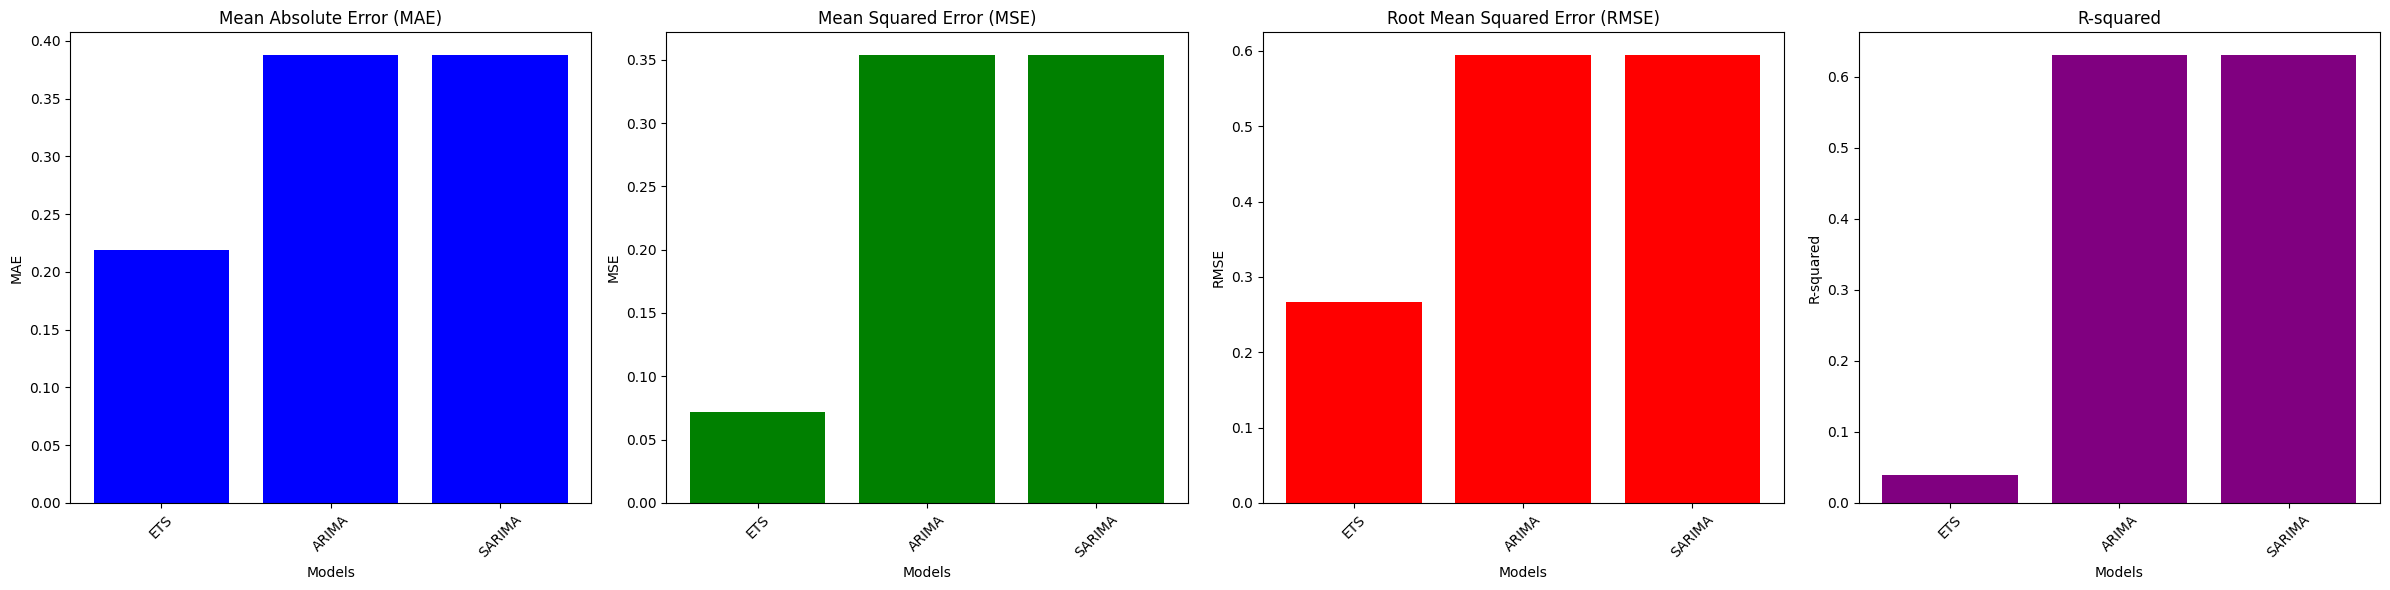

In [40]:
models = ['ETS', 'ARIMA', 'SARIMA']

mae_values = [ets_mae, arima_mae, sarima_mae]
mse_values = [ets_mse, arima_mse, sarima_mse ]
rmse_values = [ets_rmse, arima_rmse, sarima_rmse]
r2_values = [ets_r2, arima_r2, sarima_r2]

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(24, 6))

# Plotting MAE
axes[0].bar(models, mae_values, color='blue')
axes[0].set_title('Mean Absolute Error (MAE)')
axes[0].set_xlabel('Models')
axes[0].set_ylabel('MAE')
axes[0].set_xticklabels(models, rotation=45)

# Plotting MSE
axes[1].bar(models, mse_values, color='green')
axes[1].set_title('Mean Squared Error (MSE)')
axes[1].set_xlabel('Models')
axes[1].set_ylabel('MSE')
axes[1].set_xticklabels(models, rotation=45)

# Plotting RMSE
axes[2].bar(models, rmse_values, color='red')
axes[2].set_title('Root Mean Squared Error (RMSE)')
axes[2].set_xlabel('Models')
axes[2].set_ylabel('RMSE')
axes[2].set_xticklabels(models, rotation=45)

# Plotting R-squared
axes[3].bar(models, r2_values, color='purple')
axes[3].set_title('R-squared')
axes[3].set_xlabel('Models')
axes[3].set_ylabel('R-squared')
axes[3].set_xticklabels(models, rotation=45)

plt.tight_layout()
plt.show()